In [582]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [583]:
sign_train = pd.read_csv("sign_mnist_train.csv")
sign_test = pd.read_csv("sign_mnist_test.csv")
sign_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [584]:
sign_train.shape

(27455, 785)

## Data Preprocessing

In [585]:
y = sign_train.label
y_test = sign_test.label
y.shape, y_test.shape

((27455,), (7172,))

In [586]:
sign_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [587]:
train_images = sign_train.iloc[:, 1:].values.reshape(-1, 28, 28)
test_images = sign_test.iloc[:, 1:].values.reshape(-1, 28, 28)

In [588]:
train_images.shape, test_images.shape


((27455, 28, 28), (7172, 28, 28))

In [589]:
def plot_images(data):
    selected_index = np.random.choice(data.shape[0], 10, replace=True)
    fig, axes = plt.subplots(2,5, figsize=(7, 5))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(train_images[selected_index][i],  cmap='gray', interpolation='bicubic')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

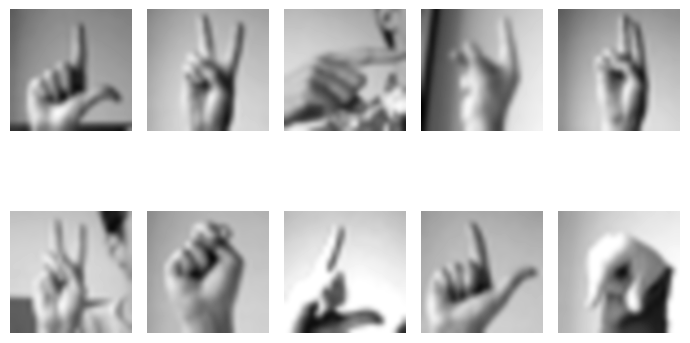

In [590]:
plot_images(test_images)

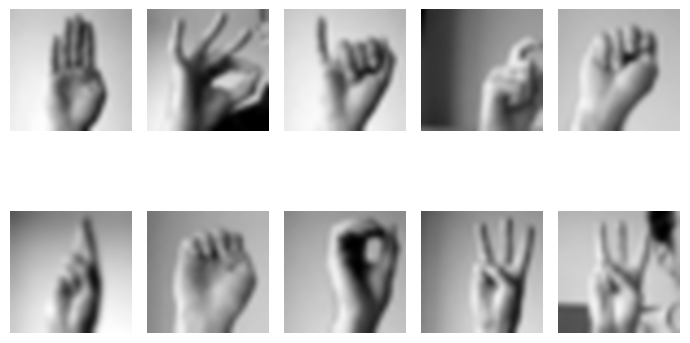

In [591]:
plot_images(train_images)

In [592]:
y.nunique()

24

In [593]:
X_train, X_val, y_train, y_val = train_test_split(train_images, y, test_size=0.1, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((24709, 28, 28), (24709,), (2746, 28, 28), (2746,))

In [594]:
X_train_normalised = X_train/255
X_val_normalised = X_val/255
X_test_normalised = test_images/255

In [596]:
map_labels = lambda label: label-1 if label > 9 else label

In [598]:
if 'y_test_original' not in globals():
    y_train_original = y_train.copy()
    y_val_original = y_val.copy()
    y_test_original = y_test.copy()
    
    
y_train = y_train_original.apply(map_labels)
y_val  = y_val_original.apply(map_labels)
y_test = y_test_original.apply(map_labels)

y_test

0        6
1        5
2        9
3        0
4        3
        ..
7167     1
7168    11
7169     2
7170     4
7171     2
Name: label, Length: 7172, dtype: int64

In [599]:
y_train_encoded = to_categorical(y_train, num_classes=24)
y_val_encoded = to_categorical(y_val, num_classes=24)
y_test_encoded = to_categorical(y_test, num_classes=24)
y_train.nunique()

24

In [600]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('final_model.hdf5', monitor='val_loss', save_best_only=True)


In [601]:
datagen = ImageDataGenerator(
                   rotation_range=10,
                   width_shift_range=0.0,
                   height_shift_range=0.1,
                   zoom_range=0.1
                   )
train_generator = datagen.flow(X_train_normalised.reshape(-1, 28, 28, 1), y_train_encoded, batch_size=32, shuffle=False)

In [628]:
def create_ann_model(model=None, input_shape=(28, 28, 1)):
    if model is None:
        model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))

    model.add(Dense(24, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
ann_model = create_ann_model()
ann_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 784)               0         
                                                                 
 dense_97 (Dense)            (None, 256)               200960    
                                                                 
 dense_98 (Dense)            (None, 128)               32896     
                                                                 
 dense_99 (Dense)            (None, 24)                3096      
                                                                 
Total params: 236952 (925.59 KB)
Trainable params: 236952 (925.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [629]:
for images, label in train_generator:
    print(images.shape)
    print(label.shape)
    break;

(32, 28, 28, 1)
(32, 24)


In [630]:
non_augmented_ann_model = create_ann_model()
ann_history_non_augmented = non_augmented_ann_model.fit(X_train_normalised.reshape(-1, 28, 28, 1), y_train_encoded, 
                                                        validation_data=(X_val_normalised.reshape(-1, 28, 28, 1), y_val_encoded), 
                                                        epochs=10, callbacks=[early_stopping])

Epoch 1/10
773/773 [==============================] - 5s 5ms/step - loss: 1.9647 - accuracy: 0.3970 - val_loss: 1.3371 - val_accuracy: 0.5648
Epoch 2/10
773/773 [==============================] - 4s 5ms/step - loss: 1.0126 - accuracy: 0.6755 - val_loss: 0.9423 - val_accuracy: 0.6752
Epoch 3/10
773/773 [==============================] - 4s 5ms/step - loss: 0.6579 - accuracy: 0.7913 - val_loss: 0.5339 - val_accuracy: 0.8343
Epoch 4/10
773/773 [==============================] - 4s 5ms/step - loss: 0.4548 - accuracy: 0.8584 - val_loss: 0.3819 - val_accuracy: 0.8842
Epoch 5/10
773/773 [==============================] - 4s 5ms/step - loss: 0.2908 - accuracy: 0.9125 - val_loss: 0.2852 - val_accuracy: 0.9137
Epoch 6/10
773/773 [==============================] - 4s 5ms/step - loss: 0.2010 - accuracy: 0.9415 - val_loss: 0.1643 - val_accuracy: 0.9541
Epoch 7/10
773/773 [==============================] - 4s 5ms/step - loss: 0.1485 - accuracy: 0.9558 - val_loss: 0.1290 - val_accuracy: 0.9690
Epoch 

In [631]:
non_augmented_ann_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 1s 3ms/step - loss: 1.0825 - accuracy: 0.7662


[1.0825225114822388, 0.7661740183830261]

In [632]:
augmented_ann_model = create_ann_model()
ann_history_augmented = augmented_ann_model.fit(train_generator, 
                                                validation_data=(X_val_normalised.reshape(-1, 28,28, 1), y_val_encoded), 
                                                epochs=10, callbacks=[early_stopping])

Epoch 1/10
773/773 [==============================] - 11s 12ms/step - loss: 2.2939 - accuracy: 0.2924 - val_loss: 1.4973 - val_accuracy: 0.5087
Epoch 2/10
773/773 [==============================] - 9s 12ms/step - loss: 1.5324 - accuracy: 0.5060 - val_loss: 1.1723 - val_accuracy: 0.6074
Epoch 3/10
773/773 [==============================] - 9s 12ms/step - loss: 1.2301 - accuracy: 0.5938 - val_loss: 0.8102 - val_accuracy: 0.7378
Epoch 4/10
773/773 [==============================] - 9s 12ms/step - loss: 1.0198 - accuracy: 0.6650 - val_loss: 0.7034 - val_accuracy: 0.7688
Epoch 5/10
773/773 [==============================] - 10s 13ms/step - loss: 0.8880 - accuracy: 0.7034 - val_loss: 0.5702 - val_accuracy: 0.8044
Epoch 6/10
773/773 [==============================] - 10s 12ms/step - loss: 0.7720 - accuracy: 0.7405 - val_loss: 0.4873 - val_accuracy: 0.8602
Epoch 7/10
773/773 [==============================] - 9s 12ms/step - loss: 0.6795 - accuracy: 0.7723 - val_loss: 0.4288 - val_accuracy: 0.8

In [644]:
augmented_ann_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 1s 3ms/step - loss: 0.5664 - accuracy: 0.8218


[0.5664172172546387, 0.8218070268630981]

In [617]:
def create_cnn_model(model=None, input_shape=(28,28,1)):
    if model is None:
        model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))



    model.add(Flatten())

    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=24, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_72 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_73 (Dropout)        (None, 7, 7, 64)        

In [633]:
def create_cnn_model(model=None, input_shape=(28,28,1)):
    if model is None:
        model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))



    model.add(Flatten())

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=24, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_88 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_89 (Dropout)        (None, 7, 7, 64)        

In [634]:
non_augmented_cnn_model = create_cnn_model()
cnn_history_non_augmented = non_augmented_cnn_model.fit(x=X_train_normalised.reshape(-1, 28, 28, 1), y=y_train_encoded, 
                                                        epochs=10, validation_data=(X_val_normalised.reshape(-1, 28, 28, 1), y_val_encoded), 
                                                        callbacks=[early_stopping])

Epoch 1/10
773/773 [==============================] - 53s 66ms/step - loss: 2.5701 - accuracy: 0.1898 - val_loss: 0.7941 - val_accuracy: 0.7207
Epoch 2/10
773/773 [==============================] - 54s 71ms/step - loss: 0.6230 - accuracy: 0.7714 - val_loss: 0.1134 - val_accuracy: 0.9665
Epoch 3/10
773/773 [==============================] - 53s 69ms/step - loss: 0.2537 - accuracy: 0.9148 - val_loss: 0.0317 - val_accuracy: 0.9909
Epoch 4/10
773/773 [==============================] - 59s 76ms/step - loss: 0.1493 - accuracy: 0.9546 - val_loss: 0.0099 - val_accuracy: 0.9996
Epoch 5/10
773/773 [==============================] - 56s 73ms/step - loss: 0.1064 - accuracy: 0.9681 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/10
773/773 [==============================] - 62s 80ms/step - loss: 0.0794 - accuracy: 0.9775 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 7/10
773/773 [==============================] - 60s 78ms/step - loss: 0.0703 - accuracy: 0.9813 - val_loss: 9.8773e-04 - val_accur

In [635]:
non_augmented_cnn_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 3s 13ms/step - loss: 0.1734 - accuracy: 0.9612


[0.1734226793050766, 0.9612381458282471]

In [636]:
augmented_cnn_model = create_cnn_model()
cnn_history_augmented = augmented_cnn_model.fit(train_generator, epochs=10, 
              validation_data=(X_val_normalised.reshape(-1, 28, 28, 1), y_val_encoded), 
              callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
773/773 [==============================] - 56s 69ms/step - loss: 2.7172 - accuracy: 0.1417 - val_loss: 1.5351 - val_accuracy: 0.3918
Epoch 2/10
773/773 [==============================] - 53s 68ms/step - loss: 1.1897 - accuracy: 0.5577 - val_loss: 0.4034 - val_accuracy: 0.8536
Epoch 3/10
773/773 [==============================] - 60s 77ms/step - loss: 0.6187 - accuracy: 0.7825 - val_loss: 0.1614 - val_accuracy: 0.9501
Epoch 4/10
773/773 [==============================] - 57s 73ms/step - loss: 0.3970 - accuracy: 0.8694 - val_loss: 0.0361 - val_accuracy: 0.9927
Epoch 5/10
773/773 [==============================] - 58s 75ms/step - loss: 0.2961 - accuracy: 0.9063 - val_loss: 0.0205 - val_accuracy: 0.9956
Epoch 6/10
773/773 [==============================] - 58s 74ms/step - loss: 0.2392 - accuracy: 0.9281 - val_loss: 0.0290 - val_accuracy: 0.9934
Epoch 7/10
773/773 [==============================] - 59s 76ms/step - loss: 0.2026 - accuracy: 0.9392 - val_loss: 0.0072 - val_accuracy:

In [637]:
augmented_cnn_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 3s 13ms/step - loss: 0.0093 - accuracy: 0.9964


[0.00932961143553257, 0.996374785900116]

In [638]:
import copy
history = copy.deepcopy(cnn_history_augmented)
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

def plot_accuracy(acc, val_acc, loss, val_loss):
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(acc, label='train')
    ax[0].plot(val_acc, label='validation')
    ax[1].plot(loss, label='train')
    ax[1].plot(val_loss, label='validation')
    ax[0].set_ylabel('accuracy')
    ax[1].set_ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

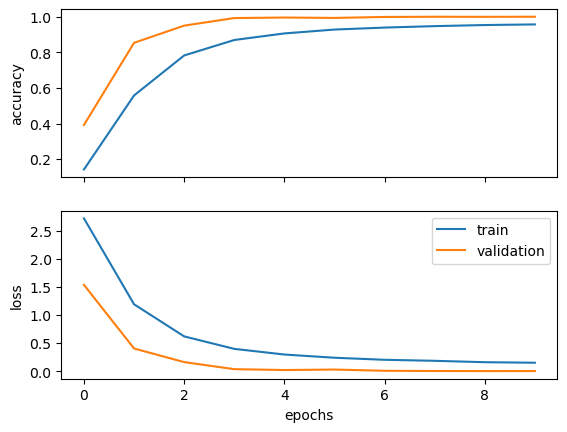

In [639]:
plot_accuracy(acc, val_acc, loss, val_loss)

In [640]:
predictions = augmented_cnn_model.predict(X_test_normalised.reshape(-1, 28, 28, 1))
predicted_labels = [np.argmax(i) for i in predictions]
predicted_labels[:5]

225/225 [==============================] - 3s 13ms/step


[6, 5, 9, 0, 3]

In [641]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       0.95      1.00      0.97       394
          12       1.00      0.92      0.96       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.99      1.00      1.00       144
          17       1.00    

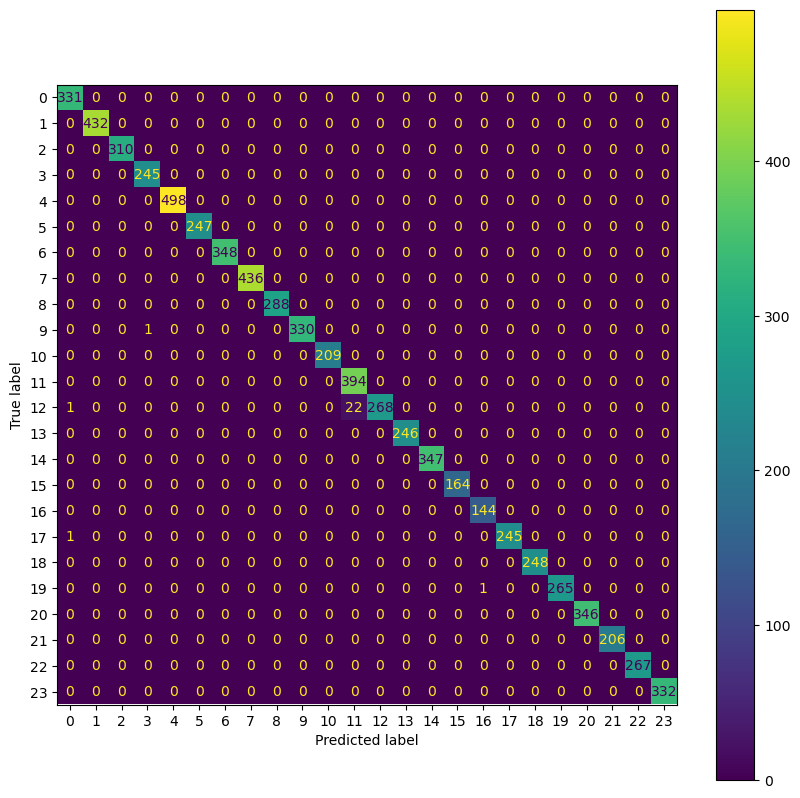

In [642]:
fig, ax = plt.subplots(figsize=(10,10))

matrix_plot = confusion_matrix(y_test, predicted_labels)

disp = ConfusionMatrixDisplay(matrix_plot)
disp.plot(ax=ax)
